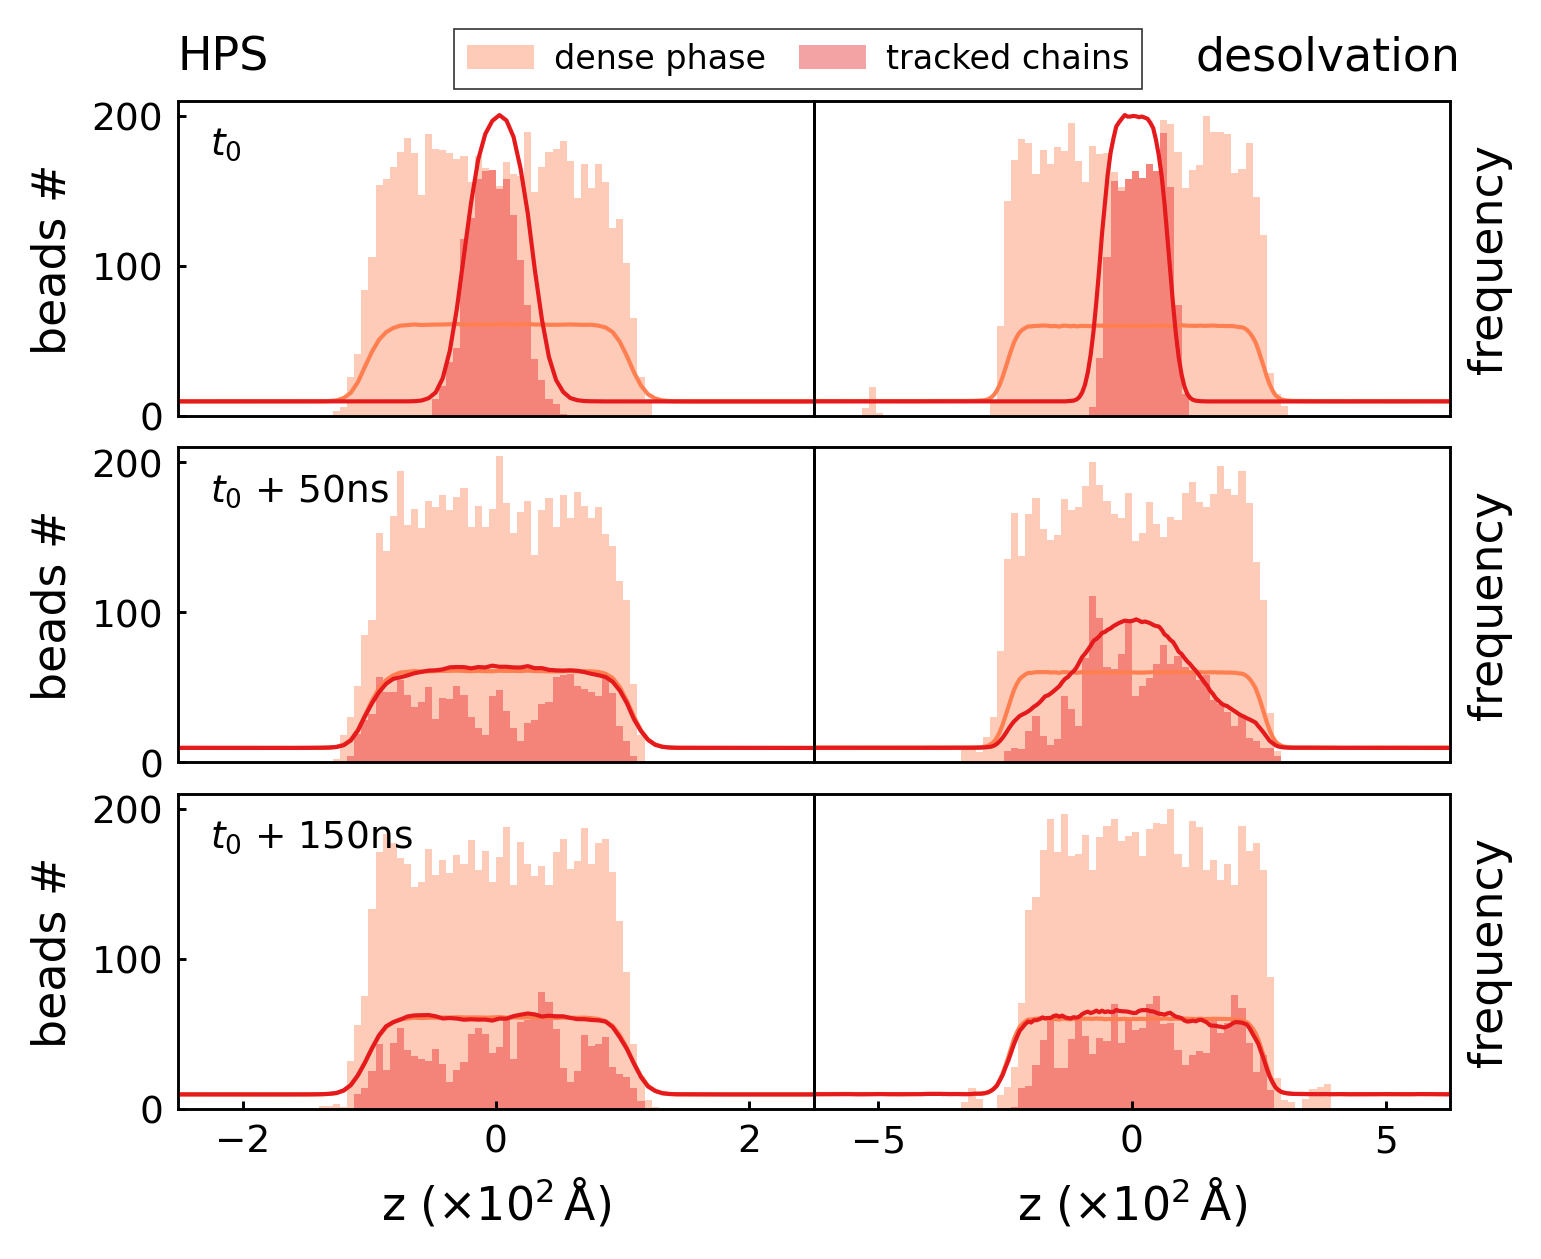

In [ ]:
# Fig. B
import os
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import networkx as nx

Tstar_scale = 0.009935
density_scale = 1000 / (50*110) # mg/mL -> mM

def plot_diffusion_schematic(folder, ax):

    t_sim = '250'
    t_length1 = 50
    t_length2 = 150
    frame_start = 100

    color_dense = '#FF7F50'
    color_track = '#E41A1C'
    
    traj_dir = f'traj/poly50/{folder}/{t_sim}/{t_sim}'
    u = mda.Universe(f'{traj_dir}.gsd', f'{traj_dir}.dcd')
    natoms = u.atoms.n_atoms
    nres = 50
    nchains = natoms // nres
    mass = u.atoms.masses
    box = u.dimensions
    lenx, leny, lenz = box[0], box[1], box[2]
    zmax, zmin = lenz / 2, - lenz / 2
    nlen = len(u.trajectory)
    if folder == 'hps':
        nbins = 500
    else:
        nbins = 200

    ## Check the starting frame, select the chains at the center of the condensed phase
    ts = u.trajectory[frame_start]

    # Determine the boundary of the condensed phase
    mc_z = []
    for i in range(nchains):
        mol = u.select_atoms('index %i:%i'%(i*50, (i+1)*50-1))
        mc_z.append(mol.center_of_mass()[2])

    dist_map = np.zeros((nchains, nchains))
    for i in range(nchains):
        for j in range(i, nchains):
            dist = min(abs(mc_z[i] - mc_z[j]), lenz - abs(mc_z[i] - mc_z[j]))
            dist_map[i, j] = dist
    dist_map += dist_map.T
    adj_map = np.where(dist_map<=5, 1, 0)
    net = nx.from_numpy_matrix(adj_map)
    idx_dense = list(max(nx.connected_components(net), key=len))
    mc_z_dense = np.array(mc_z).take(idx_dense)
    left_boundary = min(mc_z_dense)
    right_boundary = max(mc_z_dense)

    # Select chains
    deltaz = 0.25 * (right_boundary - left_boundary)
    idx_track = []
    for i in idx_dense:
        if abs(mc_z[i] - (left_boundary + right_boundary)/2) <= deltaz / 2:
            idx_track.append(i)

    # Plot density of the condensed phase and tracked chains at the starting frame
    ts = u.trajectory[frame_start]
    cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
    posz, posz_track = [], []
    for i in range(natoms):
        nposz = ts.positions[i][2] - cmassz
        if nposz < zmin:
            nposz += lenz
        if nposz > zmax:
            nposz -= lenz
        posz.append(nposz)
        if int(i/nres) in idx_track:
            posz_track.append(nposz)

    xlim = (right_boundary - left_boundary) * 0.1 * 1.15
    leftx = -xlim
    rightx = xlim
    ax[0].hist(np.array(posz)*0.1, bins=nbins, range=[zmin*0.1, zmax*0.1], alpha=0.4, label='dense phase', color=color_dense)
    ax[0].hist(np.array(posz_track)*0.1, bins=nbins, range=[zmin*0.1, zmax*0.1], alpha=0.4, label='tracked chains', color=color_track)
    if folder == 'hps':
        ax[0].set_ylabel('beads #', fontsize=11)
    else:
        ax[0].set_yticks([])
    ax[0].tick_params(labelsize=9, direction='in', length=2, width=0.7)
    # ax[0].legend(fontsize=8, frameon=False)
    ax[0].set_xlim(leftx, rightx)
    if folder == 'hps':
        ax[0].set_ylim(0, 210)
    # else:
    #     ax[0].set_ylim(0, 280)
    ax[0].set_xticks([])
    ax[0].spines['top'].set_linewidth(0.6)
    ax[0].spines['left'].set_linewidth(0.6)
    ax[0].spines['right'].set_linewidth(0.6)
    ax[0].spines['bottom'].set_linewidth(0.6)

    # Plot density of the condensed phase and tracked chains at the end frame
    ts = u.trajectory[frame_start + t_length1]
    cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
    posz_t1, posz_t1_track = [], []
    for i in range(natoms):
        nposz = ts.positions[i][2] - cmassz
        if nposz < zmin:
            nposz += lenz
        if nposz > zmax:
            nposz -= lenz
        posz_t1.append(nposz)
        if int(i/nres) in idx_track:
            posz_t1_track.append(nposz)

    ax[1].hist(np.array(posz_t1)*0.1, bins=nbins, range=[zmin*0.1, zmax*0.1], alpha=0.4, label='dense phase', color=color_dense)
    ax[1].hist(np.array(posz_t1_track)*0.1, bins=nbins, range=[zmin*0.1, zmax*0.1], alpha=0.4, label='tracked chains', color=color_track)
    if folder == 'hps':
        ax[1].set_ylabel('beads #', fontsize=11)
    else:
        ax[1].set_yticks([])
    ax[1].tick_params(labelsize=9, direction='in', length=2, width=0.7)
    # ax[1].legend(fontsize=8, frameon=False)
    ax[1].set_xlim(leftx, rightx)
    if folder == 'hps':
        ax[1].set_ylim(0, 210)
    # else:
    #     ax[1].set_ylim(0, 280)
    ax[1].set_xticks([])
    ax[1].spines['top'].set_linewidth(0.6)
    ax[1].spines['left'].set_linewidth(0.6)
    ax[1].spines['right'].set_linewidth(0.6)
    ax[1].spines['bottom'].set_linewidth(0.6)

    ts = u.trajectory[frame_start + t_length2]
    cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
    posz_t2, posz_t2_track = [], []
    for i in range(natoms):
        nposz = ts.positions[i][2] - cmassz
        if nposz < zmin:
            nposz += lenz
        if nposz > zmax:
            nposz -= lenz
        posz_t2.append(nposz)
        if int(i/nres) in idx_track:
            posz_t2_track.append(nposz)

    ax[2].hist(np.array(posz_t2)*0.1, bins=nbins, range=[zmin*0.1, zmax*0.1], alpha=0.4, label='dense phase', color=color_dense)
    ax[2].hist(np.array(posz_t2_track)*0.1, bins=nbins, range=[zmin*0.1, zmax*0.1], alpha=0.4, label='tracked chains', color=color_track)
    ax[2].set_xlabel(r'z ($\times10^2\,\mathregular{\AA}$)', fontsize=11)
    if folder == 'hps':
        ax[2].set_ylabel('beads #', fontsize=11)
    else:
        ax[2].set_yticks([])
    ax[2].tick_params(labelsize=9, direction='in', length=2, width=0.7)
    # ax[2].legend(fontsize=8, frameon=False)
    ax[2].set_xlim(leftx, rightx)
    if folder == 'hps':
        ax[2].set_ylim(0, 210)
    # else:
    #     ax[2].set_ylim(0, 280)
    ax[2].spines['top'].set_linewidth(0.6)
    ax[2].spines['left'].set_linewidth(0.6)
    ax[2].spines['right'].set_linewidth(0.6)
    ax[2].spines['bottom'].set_linewidth(0.6)

    for frame in range(frame_start + 1, nlen - t_length2, 1):
        
        ts = u.trajectory[frame]

        # Determine the tracked chains
        mc_z = []
        for i in range(nchains):
            mol = u.select_atoms('index %i:%i'%(i*50, (i+1)*50-1))
            mc_z.append(mol.center_of_mass()[2])
        
        dist_map = np.zeros((nchains, nchains))
        for i in range(nchains):
            for j in range(i, nchains):
                dist = min(abs(mc_z[i]-mc_z[j]), lenz - abs(mc_z[i]-mc_z[j]))
                dist_map[i, j] = dist
        dist_map += dist_map.T
        adj_map = np.where(dist_map <= 5, 1, 0)
        net = nx.from_numpy_matrix(adj_map)
        idx_dense = list(max(nx.connected_components(net), key=len))
        mc_z_dense = np.array(mc_z).take(idx_dense)
        right_boundary = max(mc_z_dense)
        left_boundary = min(mc_z_dense)

        idx_track = []
        for i in idx_dense:
            if abs(mc_z[i] - (left_boundary + right_boundary)/2) <= deltaz / 2:
                idx_track.extend(np.arange(i*nres, (i+1)*nres))
        
        # Calculate the centered z coordinate
        cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
        posz_tmp = ts.positions[:, 2] - cmassz
        posz_tmp[np.where(posz_tmp < zmin)] += lenz
        posz_tmp[np.where(posz_tmp > zmax)] -= lenz
        posz.extend(posz_tmp)
        # Extract the tracked z coordinate
        posz_track.extend(posz_tmp.take(idx_track))
        ts = u.trajectory[frame + t_length1]
        # Calculate the centered z coordinate
        cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
        posz_tmp = ts.positions[:, 2] - cmassz
        posz_tmp[np.where(posz_tmp < zmin)] += lenz
        posz_tmp[np.where(posz_tmp > zmax)] -= lenz
        posz_t1.extend(posz_tmp)
        # Extract the tracked z coordinate
        posz_t1_track.extend(posz_tmp.take(idx_track))
        ts = u.trajectory[frame + t_length2]
        # Calculate the centered z coordinate
        cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
        posz_tmp = ts.positions[:, 2] - cmassz
        posz_tmp[np.where(posz_tmp < zmin)] += lenz
        posz_tmp[np.where(posz_tmp > zmax)] -= lenz
        posz_t2.extend(posz_tmp)

        # Extract the tracked z coordinate
        posz_t2_track.extend(posz_tmp.take(idx_track))

    hist, bins = np.histogram(posz, bins=500, range=[zmin, zmax], density=True)
    hist_track, bins_track = np.histogram(posz_track, bins=500, range=[zmin, zmax], density=True)
    ax0 = ax[0].twinx()
    maxax = np.max(hist_track) * 1.05
    minax = -np.max(hist_track) * 0.05
    xaxis = (bins[:-1] + bins[1:]) / 2
    xaxis_track = (bins_track[:-1] + bins_track[1:]) / 2
    ax0.plot(xaxis*0.1, hist, color=color_dense, linewidth=1)
    ax0.plot(xaxis_track*0.1, hist_track, color=color_track, linewidth=1)
    # ax0.text(-xlim+0.5, maxax * 0.83, r'$t$ = $t_0$', fontsize=9)
    if not folder == 'hps':
        ax0.set_ylabel('frequency', fontsize=11)
    ax0.tick_params(labelsize=9, direction='in', length=2, width=0.7)
    ax0.set_ylim(minax, maxax)
    ax0.set_yticks([])
    ax0.spines['top'].set_linewidth(0.6)
    ax0.spines['left'].set_linewidth(0.6)
    ax0.spines['right'].set_linewidth(0.6)
    ax0.spines['bottom'].set_linewidth(0.6)

    hist, bins = np.histogram(posz_t1, bins=500, range=[zmin, zmax], density=True)
    hist_track, bins_track = np.histogram(posz_t1_track, bins=500, range=[zmin, zmax], density=True)
    ax1 = ax[1].twinx()
    ax1.plot(xaxis*0.1, hist, color=color_dense, linewidth=1)
    ax1.plot(xaxis_track*0.1, hist_track, color=color_track, linewidth=1)
    # ax1.text(-xlim+0.5, maxax * 0.83, r'$t$ = $t_0$ + %i ns'%(t_length1), fontsize=9)
    if not folder == 'hps':
        ax1.set_ylabel('frequency', fontsize=11)
    ax1.tick_params(labelsize=9, direction='in', length=2, width=0.7)
    ax1.set_ylim(minax, maxax)
    ax1.set_yticks([])
    ax1.spines['top'].set_linewidth(0.6)
    ax1.spines['left'].set_linewidth(0.6)
    ax1.spines['right'].set_linewidth(0.6)
    ax1.spines['bottom'].set_linewidth(0.6)

    hist, bins = np.histogram(posz_t2, bins=500, range=[zmin, zmax], density=True)
    hist_track, bins_track = np.histogram(posz_t2_track, bins=500, range=[zmin, zmax], density=True)
    ax2 = ax[2].twinx()
    ax2.plot(xaxis*0.1, hist, color=color_dense, linewidth=1)
    ax2.plot(xaxis_track*0.1, hist_track, color=color_track, linewidth=1)
    # ax2.text(-xlim+0.5, maxax * 0.83, r'$t$ = $t_0$ + %i ns'%(t_length2), fontsize=9)
    if not folder == 'hps':
        ax2.set_ylabel('frequency', fontsize=11)
    ax2.tick_params(labelsize=9, direction='in', length=2, width=0.7)
    ax2.set_ylim(minax, maxax)
    ax2.set_yticks([])
    ax2.spines['top'].set_linewidth(0.6)
    ax2.spines['left'].set_linewidth(0.6)
    ax2.spines['right'].set_linewidth(0.6)
    ax2.spines['bottom'].set_linewidth(0.6)

    # fig.tight_layout()
    # plt.suptitle(r'$\varepsilon_{\mathregular{w}}$ = %s kcal/mol'%(option.split('_')[3]), fontsize=11, y=0.95)
    # plt.subplots_adjust(top=0.9, bottom=0.1, left=0.12, right=0.92)

fig, ax = plt.subplots(3, 2, figsize=[5.3, 4.2], facecolor='w', dpi=300)
plot_diffusion_schematic('hps', ax[:, 0])
plot_diffusion_schematic('des_0.20_0.06_0.02', ax[:, 1])
ax[0, 0].text(0, 1.1, 'HPS', transform=ax[0, 0].transAxes, fontsize=11)
ax[0, 1].text(0.6, 1.1, 'desolvation', transform=ax[0, 1].transAxes, fontsize=11)
ax[0, 0].text(0.05, 0.83, r'$t_0$', fontsize=9, transform=ax[0, 0].transAxes)
ax[1, 0].text(0.05, 0.83, r'$t_0$ + 50ns', fontsize=9, transform=ax[1, 0].transAxes)
ax[2, 0].text(0.05, 0.83, r'$t_0$ + 150ns', fontsize=9, transform=ax[2, 0].transAxes)
handles, labels = ax[0, 0].get_legend_handles_labels()
leg = fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.51, 0.97),
    ncol=2,
    frameon=True,
    fancybox=False,
    edgecolor="black",
    columnspacing=1.0,
    handletextpad=0.6,
    fontsize=8
)
leg.get_frame().set_linewidth(0.4)

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.12, right=0.92, hspace=0.1, wspace=0.)
plt.savefig("../../figures/diffusion/diff2time.svg", format="svg", bbox_inches='tight')
plt.show()

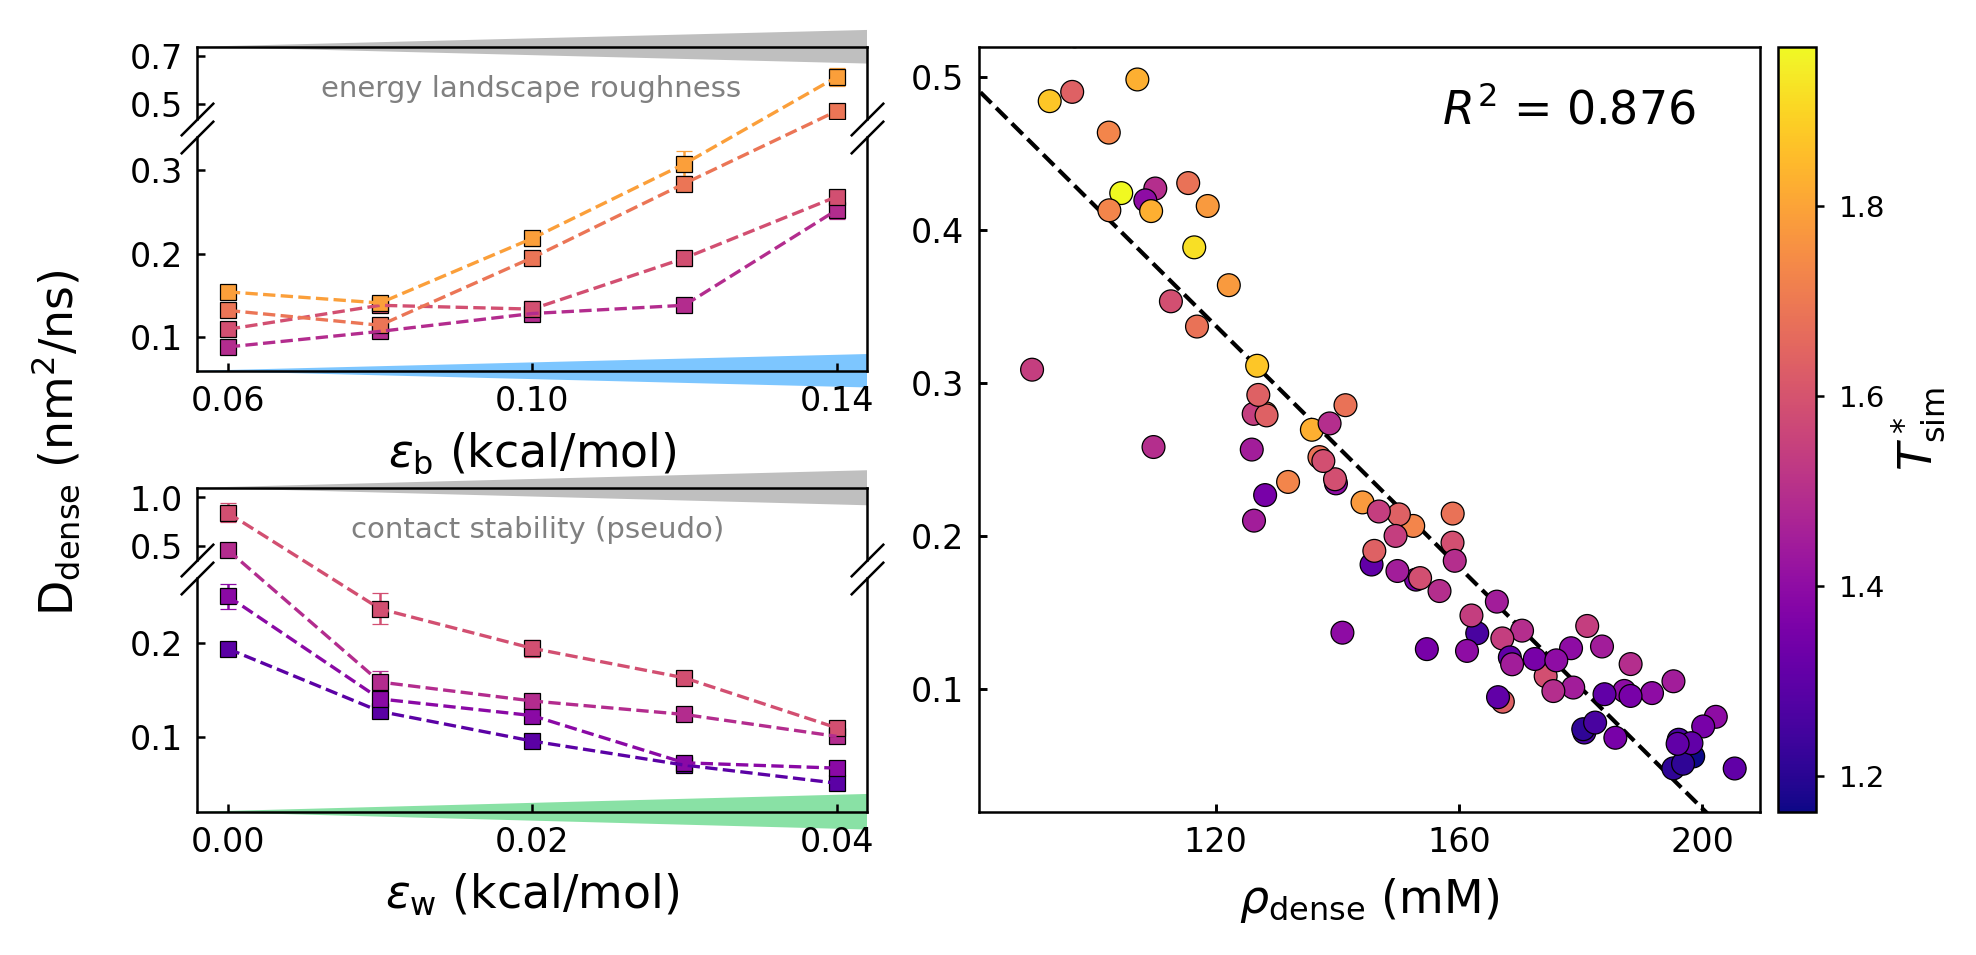

In [ ]:
## Fig.4 C
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import MDAnalysis as mda
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import minimize
from brokenaxes import brokenaxes
from sklearn.metrics import r2_score
from matplotlib.patches import Polygon

def distribution(z, D, lagtime):
    return 1 / np.sqrt(4*np.pi*D*lagtime) * np.exp(-z**2/(4*D*lagtime))

def loss_function1(params, deltaz, pdf, lagtime):
    D = params
    predict = distribution(deltaz[1:], D, lagtime)
    result = np.mean((predict - pdf) ** 2)
    return result

def loss_function2(params, deltaz, pdf, lagtime):
    D1, D2, p = params
    small_function = lambda x: p * distribution(x, D1, lagtime) + (1-p) * distribution(x, D2, lagtime)
    predict = small_function(deltaz[1:])
    result = np.mean((predict - pdf) ** 2)
    return result

def boxave(x):
    x = np.array(x)
    nbox = 5
    npoint = len(x)
    dbox = int(npoint / nbox)
    res = np.zeros(nbox)
    for i in range(nbox):
        res[i] = np.sqrt(np.mean(x[i * dbox:(i + 1) * dbox]**2))
    return np.sqrt(np.mean(x**2)), np.std(res) / np.sqrt(nbox)

def get_diffusion_data(protein, t_sim, param_idx, fix_value, label_idx):

    folders = os.listdir('traj/' + protein)
    folders.sort()
    E, D, D_ERR = [], [], []
    for option in folders:
        param = option.split('_')
        if len(param) == 1:
            continue
        if param[param_idx] != fix_value:
            continue
        if param[1] != '0.20':
            continue
        
        t_sim = str(t_sim)
        traj_folder = 'traj/' + protein + '/' + option + '/' + t_sim + '/'
        u = mda.Universe(traj_folder+t_sim+'.gsd', traj_folder+t_sim+'.dcd', pbc=True)
        nlen = len(u.trajectory)
        natoms = u.atoms.n_atoms
        nres = 50
        nchains = int(natoms/nres)
        mass = u.atoms.masses
        box = u.dimensions
        lenx, leny, lenz = box[0], box[1], box[2]
        zmax, zmin = lenz / 2, - lenz / 2

        if os.path.exists('data/'+protein+'/'+option+'/'+t_sim+'_posz.npy'):
            posz = np.load('data/'+protein+'/'+option+'/'+t_sim+'_posz.npy')
        else:
            posz = np.zeros((nlen, natoms))
            for frame in range(nlen): # make each chain complete and calculate cm
                if (frame % 100) == 0:
                    print(frame)
                ts = u.trajectory[frame]
                for i in range(nchains): 
                    mol_coord = ts.positions[i*nres:(i+1)*nres, 2]
                    for j in range(1, nres):
                        dist2 = (mol_coord[j] - mol_coord[j-1])**2
                        if dist2 > 8:
                            excess = np.sign(mol_coord[j] - mol_coord[j-1]) * lenz
                            mol_coord[j] = mol_coord[j] - excess
                        com = np.mean(mol_coord)
                        if com < zmin:
                            mol_coord += lenz
                        elif com > zmax:
                            mol_coord -= lenz
                    posz[frame, i*nres:(i+1)*nres] = mol_coord
            for frame in range(1, nlen): # remove pbc
                for i in range(natoms):
                    dist = abs(posz[frame, i] - posz[frame-1, i])
                    if dist > lenz / 2:
                        excess = np.sign(posz[frame, i] - posz[frame-1, i]) * lenz
                        posz[frame, i] -= excess
            for frame in range(nlen): # center trajectory
                posz[frame, :] -= np.mean(posz[frame, :])
                posz[frame, :] -= np.mean(posz[frame, np.where(abs(posz[frame, :]) < 100)])
            
            np.save('data/'+protein+'/'+option+'/'+t_sim+'_posz.npy', posz)
        
        D_list = []
        for lagtime in range(500, 925, 100):
            dispz = posz[lagtime:] - posz[0:nlen-lagtime]
            pdf, deltaz = np.histogram(dispz, bins=np.linspace(-200, 200, 300), density=True)
            if np.mean(pdf[:100]) < 0.0003:
                res = minimize(fun=loss_function1, x0=[0.1], args=(deltaz, pdf, lagtime), method='Nelder-Mead')
                D1 = res.x[0]
            else:
                res = minimize(fun=loss_function2, x0=[0.1, 10, 0.9], args=(deltaz, pdf, lagtime), method='Nelder-Mead')
                D1 = res.x[0]
            D_list.append(D1)
        
        aved, errd = boxave(D_list)

        e_value = float(param[label_idx])
        D.append(aved)
        D_ERR.append(errd)
        E.append(e_value)
    
    return np.array(D), np.array(D_ERR), np.array(E)

def data_to_fig_coords(ax, x, y, fig):
    pts = np.vstack([x, y]).T
    disp = ax.transData.transform(pts)
    return fig.transFigure.inverted().transform(disp)

def err_Tc(param, T, delta_rho):
    A, Tc = param
    beta = 0.325
    return A * (Tc - T)**beta - delta_rho

def err_rhoc(param, T, rho_ave):
    B, C = param
    return rho_ave - (B + C * T)

Tstar_scale = 0.009935
density_scale = 1000 / (50*110) # mg/mL -> mM

protein = 'poly50'
T_list_eb = np.array([150, 160, 170, 180])
T_list_ew = np.array([130, 140, 150, 160])
T_list_all = np.concatenate([T_list_eb, T_list_ew]) * Tstar_scale
cmap = cm.plasma
norm = Normalize(vmin=T_list_all.min()*0.9, vmax=T_list_all.max()*1.1)

# generate plot data
diff_eb_list, diff_eb_err_list, eb_values_list = [], [], []
for i, T in enumerate(T_list_eb):
    diff_eb, diff_eb_err, eb_values = get_diffusion_data(protein, T, 3, '0.02', 2)
    diff_eb_list.append(diff_eb)
    diff_eb_err_list.append(diff_eb_err)
    eb_values_list.append(eb_values)

diff_ew_list, diff_ew_err_list, ew_values_list = [], [], []
for i, T in enumerate(T_list_ew):
    diff_ew, diff_ew_err, ew_values = get_diffusion_data(protein, T, 2, '0.12', 3)
    diff_ew_list.append(diff_ew)
    diff_ew_err_list.append(diff_ew_err)
    ew_values_list.append(ew_values)

diff_all, rho_dense_all, temp_all = [], [], []
folders = os.listdir('traj/poly50/')
for folder in folders:
    if folder == 'hps' or folder == 'data' or folder == 'data0':
        continue
    print(folder)
    rho_h_list, rho_l_list, t_list = [], [], []
    for T_sim in range(0, 1000, 10):
        traj_folder = 'traj/poly50/' + folder + '/' + str(T_sim) + '/'
        data_folder = 'data/poly50/' + folder + '/'
        param = folder.split('_')
        if len(param) == 1:
            continue
        if not os.path.exists(traj_folder):
            continue

        gsdfile = traj_folder + str(T_sim) + '.gsd'
        dcdfile = traj_folder + str(T_sim) + '.dcd'
        u = mda.Universe(gsdfile, dcdfile)
        nlen = len(u.trajectory)
        natoms = u.atoms.n_atoms
        nres = 50
        nchains = int(natoms/nres)
        mass = u.atoms.masses
        box = u.dimensions
        lenx, leny, lenz = box[0], box[1], box[2]
        zmax, zmin = lenz / 2, - lenz / 2
        nbins = 500
        dz = lenz / nbins

        ## obtain the density data
        if os.path.exists(data_folder + str(T_sim) + '_dp.npy'):
            rhoave = np.load(data_folder + str(T_sim) + '_dp.npy')
        else:
            count = 0
            rhosum = np.zeros(nbins)
            for frame in np.arange(300, nlen, 2):
                if frame % 100 == 0:
                    print(frame)
                ts = u.trajectory[frame]
                cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
                massz = np.zeros(nbins)
                for i in range(natoms):
                    nposz = ts.positions[i][2] - cmassz
                    nmass = mass[i]
                    idx = int((nposz - zmin) / dz)
                    if idx >= 500:
                        idx -= 500
                    if idx < 0:
                        idx += 500
                    massz[idx] += nmass
                rhoz = massz / (lenx * leny * dz * 6.02214e-1)
                rhosum += rhoz
                count += 1
            rhoave = rhosum / count
            rhoidx = np.where(rhoave > max(rhoave) * 0.2)
            mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
            if mc_idx > 0:
                tmp = rhoave[:mc_idx].copy()
                rhoave[:-mc_idx] = rhoave[mc_idx:]
                rhoave[-mc_idx:] = tmp
            if mc_idx < 0:
                tmp = rhoave[mc_idx:].copy()
                rhoave[-mc_idx:] = rhoave[:mc_idx]
                rhoave[:-mc_idx] = tmp
            
            if not os.path.exists(data_folder):
                os.makedirs(data_folder)
            np.save(data_folder + str(T_sim) + '_dp.npy', rhoave)
        
        rho_max = max(rhoave)
        rho_min = min(rhoave)
        rho_hd, rho_ld = 0, 0
        count_hd, count_ld = 0, 0
        for rho in rhoave:
            if rho >= rho_max * 0.95:
                rho_hd += rho
                count_hd += 1
            if rho <= rho_min + 50:
                rho_ld += rho
                count_ld += 1
        rho_hd /= count_hd
        rho_ld /= count_ld

        rho_hd = np.average(rhoave[int(nbins/2-5):int(nbins/2+5)])
        rho_ld = (np.average(rhoave[:180]) + np.average(rhoave[-180:])) / 2

        if abs(rho_hd - rho_ld) <= 50:
            continue
        
        rho_h_list.append(rho_hd)
        rho_l_list.append(rho_ld)
        t_list.append(T_sim)

        rho_dense_all.append(rho_hd)

        ## obtain diffusion coefficient data
        if os.path.exists(data_folder + str(T_sim) + '_posz.npy'):
            posz = np.load(data_folder + str(T_sim) + '_posz.npy')
        else:
            posz = np.zeros((nlen, natoms))
            for frame in range(nlen): # make each chain complete and calculate cm
                if (frame % 100) == 0:
                    print(frame)
                ts = u.trajectory[frame]
                for i in range(nchains): 
                    mol_coord = ts.positions[i*nres:(i+1)*nres, 2]
                    for j in range(1, nres):
                        dist2 = (mol_coord[j] - mol_coord[j-1])**2
                        if dist2 > 8:
                            excess = np.sign(mol_coord[j] - mol_coord[j-1]) * lenz
                            mol_coord[j] = mol_coord[j] - excess
                        com = np.mean(mol_coord)
                        if com < zmin:
                            mol_coord += lenz
                        elif com > zmax:
                            mol_coord -= lenz
                    posz[frame, i*nres:(i+1)*nres] = mol_coord
            for frame in range(1, nlen): # remove pbc
                for i in range(natoms):
                    dist = abs(posz[frame, i] - posz[frame-1, i])
                    if dist > lenz / 2:
                        excess = np.sign(posz[frame, i] - posz[frame-1, i]) * lenz
                        posz[frame, i] -= excess
            for frame in range(nlen): # center trajectory
                posz[frame, :] -= np.mean(posz[frame, :])
                posz[frame, :] -= np.mean(posz[frame, np.where(abs(posz[frame, :]) < 100)])
            
            np.save(data_folder + str(T_sim) + '_posz.npy', posz)
        
        D_list = []
        for lagtime in range(700, 925, 25):
            dispz = posz[lagtime:] - posz[0:nlen-lagtime]
            pdf, deltaz = np.histogram(dispz, bins=np.linspace(-200, 200, 300), density=True)
            if np.mean(pdf[:100]) < 0.0003:
                res = minimize(fun=loss_function1, x0=[0.1], args=(deltaz, pdf, lagtime), method='Nelder-Mead')
                D1 = res.x[0]
            else:
                res = minimize(fun=loss_function2, x0=[0.1, 10, 0.9], args=(deltaz, pdf, lagtime), method='Nelder-Mead')
                D1 = res.x[0]
            D_list.append(D1)

        diff_all.append(np.mean(D_list))
        temp_all.append(T_sim)

temp_all = np.array(temp_all) * Tstar_scale
diff_all = np.array(diff_all)
rho_dense_all = np.array(rho_dense_all) * density_scale

# plot figures
fig = plt.figure(figsize=(6.2, 3), dpi=300)
gs_left = gridspec.GridSpec(4, 1, height_ratios=[1, 3, 1, 3], hspace=0)
gs_right = gridspec.GridSpec(1, 1)
ax1 = fig.add_subplot(gs_left[0, 0])
ax2 = fig.add_subplot(gs_left[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs_left[2, 0])
ax4 = fig.add_subplot(gs_left[3, 0], sharex=ax3)
ax5 = fig.add_subplot(gs_right[0])

gap12 = 0.02        # ax1-ax2 间距
gap34 = 0.02        # ax3-ax4 间距
gap_mid = 0.13      # ax2-ax3 间距

left_x0 = 0.10
left_w  = 0.36      # 左列宽
right_x0 = 0.52
right_w  = 0.42      # 右列宽

h1, h2, h3, h4 = 0.08, 0.26, 0.08, 0.26
y4 = 0.02
y3 = y4 + h4 + gap34
y2 = y3 + h3 + gap_mid
y1 = y2 + h2 + gap12

ax1.set_position([left_x0, y1, left_w, h1])
ax2.set_position([left_x0, y2, left_w, h2])
ax3.set_position([left_x0, y3, left_w, h3])
ax4.set_position([left_x0, y4, left_w, h4])
ax5.set_position([right_x0, 0.02, right_w, y1 + h1 - 0.02])

# === 上子图：ε_b ===
for i, T in enumerate(T_list_eb):
    diff_eb, diff_eb_err, eb_values = diff_eb_list[i], diff_eb_err_list[i], eb_values_list[i]
    T *= Tstar_scale
    mask_high = diff_eb > 0.35
    x_high, y_high, yerr_high = eb_values[mask_high], diff_eb[mask_high], diff_eb_err[mask_high]
    x_low, y_low, yerr_low = eb_values[~mask_high], diff_eb[~mask_high], diff_eb_err[~mask_high]
    ax1.errorbar(x_high, y_high, yerr_high, fmt='s', markerfacecolor=cmap(norm(T)), markeredgecolor='k', markersize=4, markeredgewidth=0.3, linestyle='none', ecolor=cmap(norm(T)), capsize=2, elinewidth=0.6, capthick=0.6, zorder=1000)
    ax2.errorbar(x_low, y_low, yerr_low, fmt='s', markerfacecolor=cmap(norm(T)), markeredgecolor='k', markersize=4, markeredgewidth=0.3, linestyle='none', ecolor=cmap(norm(T)), capsize=2, elinewidth=0.6, capthick=0.6, zorder=1000)

ax1.set_ylim(0.44, 0.74)
ax2.set_ylim(0.06, 0.34)
fig.canvas.draw()

for i, T in enumerate(T_list_eb):
    diff_eb, diff_eb_err, eb_values = diff_eb_list[i], diff_eb_err_list[i], eb_values_list[i]
    T *= Tstar_scale
    mask_high = diff_eb > 0.35
    x_high, y_high, yerr_high = eb_values[mask_high], diff_eb[mask_high], diff_eb_err[mask_high]
    x_low, y_low, yerr_low = eb_values[~mask_high], diff_eb[~mask_high], diff_eb_err[~mask_high]
    if len(x_low) + len(x_high) >= 2:
        fig_coords_low = np.empty((0,2))
        fig_coords_high = np.empty((0,2))
        if len(x_low):
            fig_coords_low = data_to_fig_coords(ax2, x_low, y_low, fig)
        if len(x_high):
            fig_coords_high = data_to_fig_coords(ax1, x_high, y_high, fig)
        x_all = np.concatenate([x_low, x_high]) if (len(x_low) and len(x_high)) else (x_low if len(x_low) else x_high)
        fig_all = np.vstack([fig_coords_low, fig_coords_high]) if (len(fig_coords_low) and len(fig_coords_high)) else (fig_coords_low if len(fig_coords_low) else fig_coords_high)
        order = np.argsort(x_all)
        fig_sorted = fig_all[order]
        line = mpl.lines.Line2D(fig_sorted[:,0], fig_sorted[:,1],
                                transform=fig.transFigure, color=cmap(norm(T)),
                                linestyle='--', linewidth=0.8, zorder=0, clip_on=False)
        fig.lines.append(line)

kwargs = dict(marker=[(-1, -1), (1, 1)], markersize=8,
              linestyle="none", color='k', mec='k', mew=0.6, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax2.set_xlabel(r"$\epsilon_{\mathregular{b}}$ (kcal/mol)", fontsize=11, labelpad=3)
# fig.text(0.0, 0.68, r"D (nm$^2$/ns)", va='center', rotation='vertical', fontsize=11)
ax1.tick_params(labelsize=8, direction='in', length=2, width=0.6)
ax2.tick_params(labelsize=8, direction='in', length=2, width=0.6)
ax2.set_xticks([0.06, 0.10, 0.14])
for spine in ax1.spines.values():
    spine.set_linewidth(0.6)
for spine in ax2.spines.values():
    spine.set_linewidth(0.6)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.set_yticks([0.5, 0.7])
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)

# === 下子图：ε_w ===
for i, T in enumerate(T_list_ew):
    diff_ew, diff_ew_err, ew_values = diff_ew_list[i], diff_ew_err_list[i], ew_values_list[i]
    T *= Tstar_scale
    mask_high = diff_ew > 0.35
    x_high, y_high, yerr_high = ew_values[mask_high], diff_ew[mask_high], diff_ew_err[mask_high]
    x_low, y_low, yerr_low = ew_values[~mask_high], diff_ew[~mask_high], diff_ew_err[~mask_high]
    ax3.errorbar(x_high, y_high, yerr_high, fmt='s', markerfacecolor=cmap(norm(T)), markeredgecolor='k', markersize=4, markeredgewidth=0.3, linestyle='none', ecolor=cmap(norm(T)), capsize=2, elinewidth=0.6, capthick=0.6, zorder=1000)
    ax4.errorbar(x_low, y_low, yerr_low, fmt='s', markerfacecolor=cmap(norm(T)), markeredgecolor='k', markersize=4, markeredgewidth=0.3, linestyle='none', ecolor=cmap(norm(T)), capsize=2, elinewidth=0.6, capthick=0.6, zorder=1000)

ax3.set_ylim(0.36, 1.1)
ax4.set_ylim(0.02, 0.27)
fig.canvas.draw()

for i, T in enumerate(T_list_ew):
    diff_ew, diff_ew_err, ew_values = diff_ew_list[i], diff_ew_err_list[i], ew_values_list[i]
    T *= Tstar_scale
    mask_high = diff_ew > 0.35
    x_high, y_high, yerr_high = ew_values[mask_high], diff_ew[mask_high], diff_ew_err[mask_high]
    x_low, y_low, yerr_low = ew_values[~mask_high], diff_ew[~mask_high], diff_ew_err[~mask_high]
    if len(x_low) + len(x_high) >= 2:
        fig_coords_low = np.empty((0,2))
        fig_coords_high = np.empty((0,2))
        if len(x_low):
            fig_coords_low = data_to_fig_coords(ax4, x_low, y_low, fig)
        if len(x_high):
            fig_coords_high = data_to_fig_coords(ax3, x_high, y_high, fig)
        x_all = np.concatenate([x_low, x_high]) if (len(x_low) and len(x_high)) else (x_low if len(x_low) else x_high)
        fig_all = np.vstack([fig_coords_low, fig_coords_high]) if (len(fig_coords_low) and len(fig_coords_high)) else (fig_coords_low if len(fig_coords_low) else fig_coords_high)
        order = np.argsort(x_all)
        fig_sorted = fig_all[order]
        line = mpl.lines.Line2D(fig_sorted[:,0], fig_sorted[:,1],
                                transform=fig.transFigure, color=cmap(norm(T)),
                                linestyle='--', linewidth=0.8, zorder=0, clip_on=False)
        fig.lines.append(line)

kwargs = dict(marker=[(-1, -1), (1, 1)], markersize=8,
              linestyle="none", color='k', mec='k', mew=0.6, clip_on=False)
ax3.plot([0, 1], [0, 0], transform=ax3.transAxes, **kwargs)
ax4.plot([0, 1], [1, 1], transform=ax4.transAxes, **kwargs)
ax4.set_xlabel(r"$\epsilon_{\mathregular{w}}$ (kcal/mol)", fontsize=11, labelpad=3)
ax3.tick_params(labelsize=8, direction='in', length=2, width=0.6)
ax4.tick_params(labelsize=8, direction='in', length=2, width=0.6)
ax4.set_xticks([0.00, 0.02, 0.04])
for spine in ax3.spines.values():
    spine.set_linewidth(0.6)
for spine in ax4.spines.values():
    spine.set_linewidth(0.6)
plt.setp(ax3.get_xticklabels(), visible=False)
ax3.spines.bottom.set_visible(False)
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax4.spines.top.set_visible(False)

fig.text(0.01, 0.43, r"D$_\mathregular{dense}$ (nm$^2$/ns)", va='center', rotation='vertical', fontsize=11)

# gray area
x0, x1 = ax1.get_xlim()
y0, y1 = ax1.get_ylim()
verts1 = [(x1, y1+0.07), (x1, y1-0.07), (x0, y1)]
poly1 = Polygon(verts1, closed=True, facecolor="gray", alpha=0.5, lw=0, zorder=1, clip_on=False)
ax1.add_patch(poly1)
ax1.text(0.185, 0.3, 'energy landscape roughness', transform=ax1.transAxes, fontsize=7, color='gray')

x0, x1 = ax2.get_xlim()
y0, y1 = ax2.get_ylim()
verts2 = [(x1, y0+0.02), (x1, y0-0.02), (x0, y0)]
poly2 = Polygon(verts2, closed=True, facecolor="#26A1FF", alpha=0.6, lw=0, zorder=1, clip_on=False)
ax2.add_patch(poly2)

x0, x1 = ax3.get_xlim()
y0, y1 = ax3.get_ylim()
verts3 = [(x1, y1+0.18), (x1, y1-0.18), (x0, y1)]
poly3 = Polygon(verts3, closed=True, facecolor="gray", alpha=0.5, lw=0, zorder=1, clip_on=False)
ax3.add_patch(poly3)
ax3.text(0.23, 0.3, 'contact stability (pseudo)', transform=ax3.transAxes, fontsize=7, color='gray')

x0, x1 = ax4.get_xlim()
y0, y1 = ax4.get_ylim()
verts4 = [(x1, y0+0.019), (x1, y0-0.019), (x0, y0)]
poly4 = Polygon(verts4, closed=True, facecolor="#3BCE69", alpha=0.6, lw=0, zorder=1, clip_on=False)
ax4.add_patch(poly4)

# === 右子图 ===
z = np.polyfit(rho_dense_all, diff_all, 1)
p = np.poly1d(z)
pc = np.corrcoef(rho_dense_all, diff_all)[0, 1]
R2 = r2_score(diff_all, p(rho_dense_all))

len_rho = max(rho_dense_all) - min(rho_dense_all)
len_d = max(diff_all) - min(diff_all)
rho_axis = np.arange(min(rho_dense_all)-100*density_scale, max(rho_dense_all)+100*density_scale, 1)
ax5.plot(rho_axis, p(rho_axis), 'k--', linewidth=1)
scatter = ax5.scatter(rho_dense_all, diff_all, s=30, c=temp_all, cmap=cm.plasma, edgecolors='k', linewidths=0.3, zorder=10)
ax5.set_xlabel(r'$\rho_{\mathregular{dense}}$ (mM)', fontsize=11)
# ax5.set_ylabel(r'D (nm$^2$/ns)', fontsize=11)
ax5.tick_params(labelsize=8, direction='in', length=2, width=0.7)
ax5.set_xticks([80, 120, 160, 200])
# ax5.set_xlim(min(rho_dense_all)-0.03*len_rho, max(rho_dense_all)+0.03*len_rho)
# ax5.set_ylim(min(diff_all)-0.03*len_d, max(diff_all)+0.03*len_d)
ax5.set_xlim(81, max(rho_dense_all)+0.03*len_rho)
ax5.set_ylim(0.02, 0.52)
ax5.text(max(rho_dense_all)-0.35*len_rho, 0.47,\
         r'$R^2$ = %.3f'%R2, fontsize=11)
for spine in ax5.spines.values():
    spine.set_linewidth(0.6)

# for ax in [ax1, ax2, ax3, ax4, ax5]:
#     yticks = ax.get_yticks()
#     ax.set_yticklabels([f"{y*100:.0f}" for y in yticks])

pos = ax5.get_position()
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.y1 - pos.y0])
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(r"$T_\mathregular{sim}^*$", fontsize=11, labelpad=1)
cbar.ax.tick_params(labelsize=7, length=2, width=0.6)
cbar.set_ticks([1.2, 1.4, 1.6, 1.8])
for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.6)

plt.savefig("../../figures/diffusion/diff_all.svg", format="svg", bbox_inches='tight')
plt.show()

des_0.20_0.06_0.02


/tmp/ipykernel_1581015/952928736.py:13: RuntimeWarning: invalid value encountered in sqrt
  return 1 / np.sqrt(4*np.pi*D*lagtime) * np.exp(-z**2/(4*D*lagtime))


des_0.20_0.08_0.02
des_0.20_0.10_0.02


/tmp/ipykernel_1581015/952928736.py:13: RuntimeWarning: overflow encountered in exp
  return 1 / np.sqrt(4*np.pi*D*lagtime) * np.exp(-z**2/(4*D*lagtime))


des_0.20_0.12_0.00
des_0.20_0.12_0.01
des_0.20_0.12_0.02
des_0.20_0.12_0.03
des_0.20_0.12_0.04
des_0.20_0.14_0.02


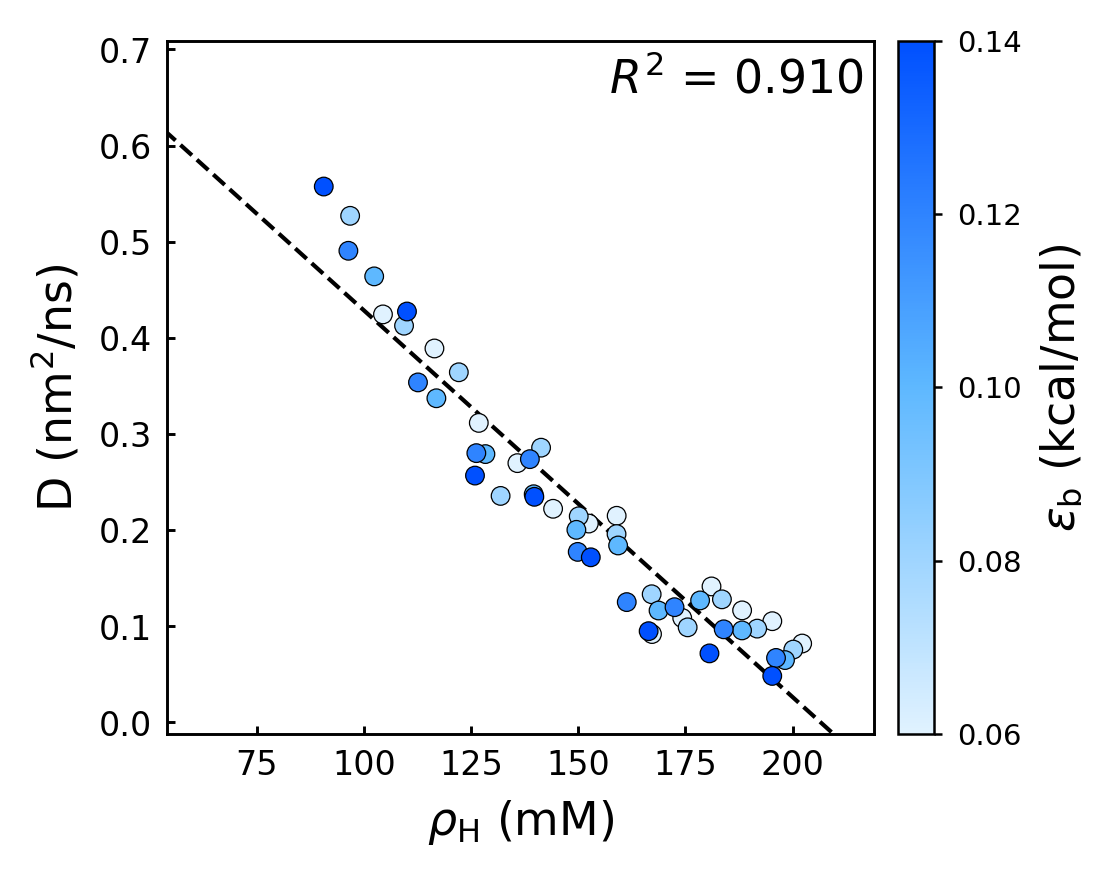

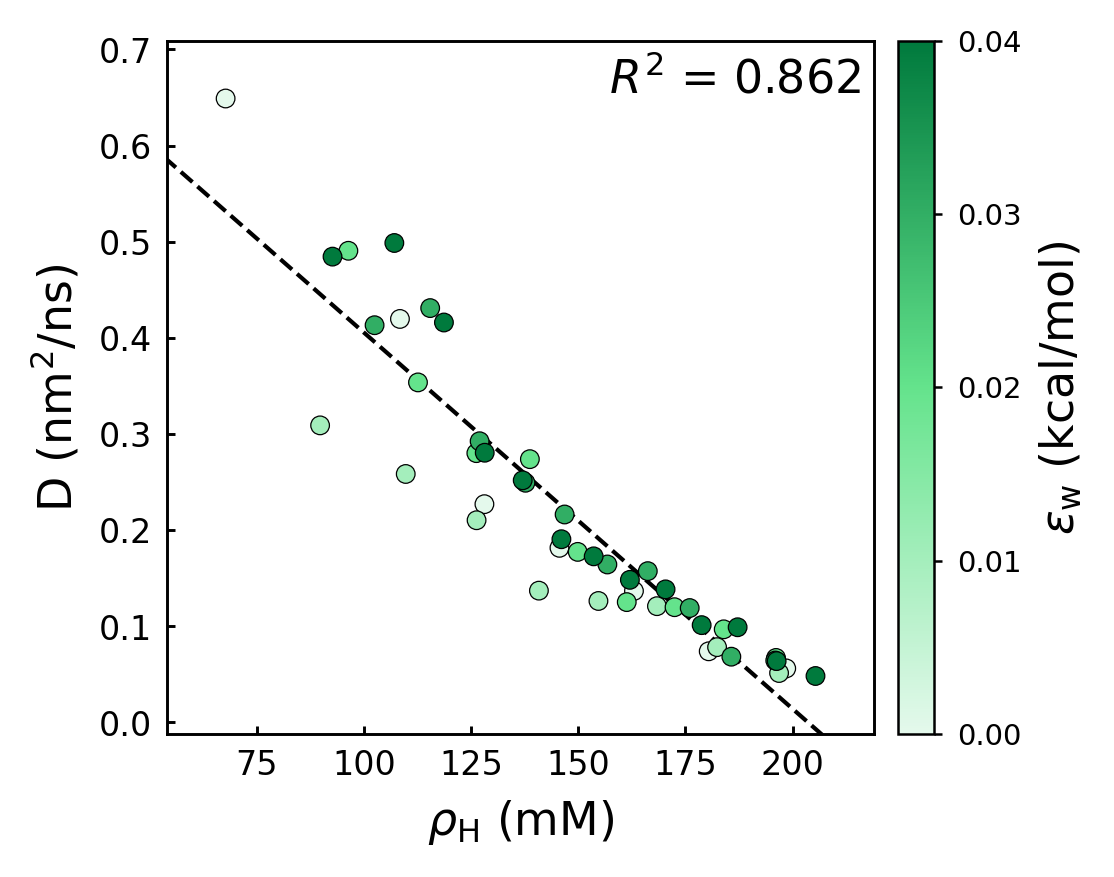

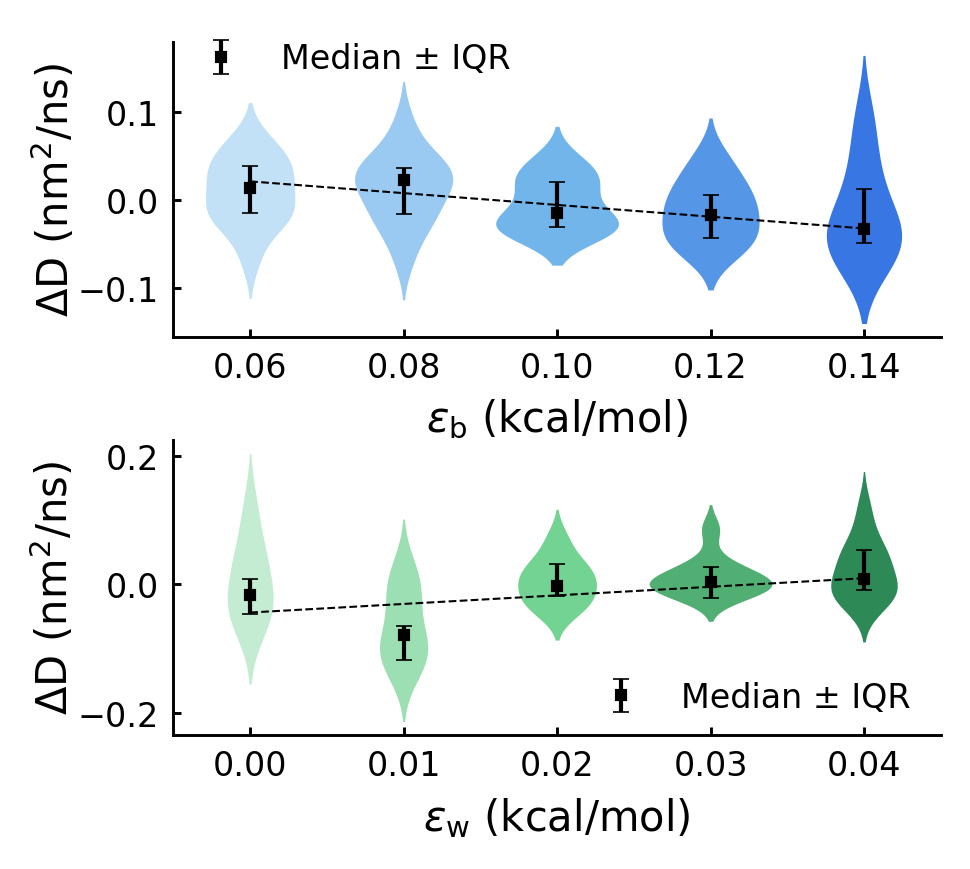

In [ ]:
# Fig.S3 + D

import sys, os
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import minimize, leastsq
from sklearn.metrics import r2_score
from matplotlib.colors import LinearSegmentedColormap

def distribution(z, D):
    return 1 / np.sqrt(4*np.pi*D*lagtime) * np.exp(-z**2/(4*D*lagtime))

def loss_function1(params):
    D = params
    predict = distribution(deltaz[1:], D)
    result = np.mean((predict - pdf) ** 2)
    return result

def loss_function2(params):
    D1, D2, p = params
    small_function = lambda x: p * distribution(x, D1) + (1-p) * distribution(x, D2)
    predict = small_function(deltaz[1:])
    result = np.mean((predict - pdf) ** 2)
    return result

def err_Tc(param, T, delta_rho):
    A, Tc = param
    beta = 0.325
    return A * (Tc - T)**beta - delta_rho

def err_rhoc(param, T, rho_ave):
    B, C = param
    return rho_ave - (B + C * T)

Db, RHO_Hb, Eb, Tb = [], [], [], []
Dw, RHO_Hw, Ew, Tw = [], [], [], []
folders = os.listdir('traj/poly50/')
folders.sort()

for folder in folders:
    if folder == 'hps' or folder[:4] == 'data':
        continue
    print(folder)
    rho_h_list, rho_l_list, t_list = [], [], []
    for T_sim in range(0, 1000, 10):
        traj_folder = 'traj/poly50/' + folder + '/' + str(T_sim) + '/'
        data_folder = 'data/poly50/' + folder + '/'
        param = folder.split('_')
        if len(param) == 1:
            continue
        if not os.path.exists(traj_folder):
            continue

        eh, eb, ew = param[1], param[2], param[3]

        gsdfile = traj_folder + str(T_sim) + '.gsd'
        dcdfile = traj_folder + str(T_sim) + '.dcd'
        u = mda.Universe(gsdfile, dcdfile)
        nlen = len(u.trajectory)
        natoms = u.atoms.n_atoms
        nres = 50
        nchains = int(natoms/nres)
        mass = u.atoms.masses
        box = u.dimensions
        lenx, leny, lenz = box[0], box[1], box[2]
        zmax, zmin = lenz / 2, - lenz / 2
        nbins = 500
        dz = lenz / nbins

        ## obtain the density data
        if os.path.exists(data_folder + str(T_sim) + '_dp.npy'):
            rhoave = np.load(data_folder + str(T_sim) + '_dp.npy')
        else:
            count = 0
            rhosum = np.zeros(nbins)
            for frame in np.arange(300, nlen, 2):
                if frame % 100 == 0:
                    print(frame)
                ts = u.trajectory[frame]
                cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
                massz = np.zeros(nbins)
                for i in range(natoms):
                    nposz = ts.positions[i][2] - cmassz
                    nmass = mass[i]
                    idx = int((nposz - zmin) / dz)
                    if idx >= 500:
                        idx -= 500
                    if idx < 0:
                        idx += 500
                    massz[idx] += nmass
                rhoz = massz / (lenx * leny * dz * 6.02214e-1)
                rhosum += rhoz
                count += 1
            rhoave = rhosum / count
            rhoidx = np.where(rhoave > max(rhoave) * 0.2)
            mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
            if mc_idx > 0:
                tmp = rhoave[:mc_idx].copy()
                rhoave[:-mc_idx] = rhoave[mc_idx:]
                rhoave[-mc_idx:] = tmp
            if mc_idx < 0:
                tmp = rhoave[mc_idx:].copy()
                rhoave[-mc_idx:] = rhoave[:mc_idx]
                rhoave[:-mc_idx] = tmp
            
            if not os.path.exists(data_folder):
                os.makedirs(data_folder)
            np.save(data_folder + str(T_sim) + '_dp.npy', rhoave)
        
        rho_max = max(rhoave)
        rho_min = min(rhoave)
        rho_hd, rho_ld = 0, 0
        count_hd, count_ld = 0, 0
        for rho in rhoave:
            if rho >= rho_max * 0.95:
                rho_hd += rho
                count_hd += 1
            if rho <= rho_min + 50:
                rho_ld += rho
                count_ld += 1
        rho_hd /= count_hd
        rho_ld /= count_ld

        rho_hd = np.average(rhoave[int(nbins/2-5):int(nbins/2+5)])
        rho_ld = (np.average(rhoave[:180]) + np.average(rhoave[-180:])) / 2

        if abs(rho_hd - rho_ld) <= 50:
            continue
        
        rho_h_list.append(rho_hd)
        rho_l_list.append(rho_ld)
        t_list.append(T_sim)

        if ew == '0.02':
            RHO_Hb.append(rho_hd)
        if eb == '0.12':
            RHO_Hw.append(rho_hd)

        ## obtain diffusion coefficient data
        if os.path.exists(data_folder + str(T_sim) + '_posz.npy'):
            posz = np.load(data_folder + str(T_sim) + '_posz.npy')
        else:
            posz = np.zeros((nlen, natoms))
            for frame in range(nlen): # make each chain complete and calculate cm
                if (frame % 100) == 0:
                    print(frame)
                ts = u.trajectory[frame]
                for i in range(nchains): 
                    mol_coord = ts.positions[i*nres:(i+1)*nres, 2]
                    for j in range(1, nres):
                        dist2 = (mol_coord[j] - mol_coord[j-1])**2
                        if dist2 > 8:
                            excess = np.sign(mol_coord[j] - mol_coord[j-1]) * lenz
                            mol_coord[j] = mol_coord[j] - excess
                        com = np.mean(mol_coord)
                        if com < zmin:
                            mol_coord += lenz
                        elif com > zmax:
                            mol_coord -= lenz
                    posz[frame, i*nres:(i+1)*nres] = mol_coord
            for frame in range(1, nlen): # remove pbc
                for i in range(natoms):
                    dist = abs(posz[frame, i] - posz[frame-1, i])
                    if dist > lenz / 2:
                        excess = np.sign(posz[frame, i] - posz[frame-1, i]) * lenz
                        posz[frame, i] -= excess
            for frame in range(nlen): # center trajectory
                posz[frame, :] -= np.mean(posz[frame, :])
                posz[frame, :] -= np.mean(posz[frame, np.where(abs(posz[frame, :]) < 100)])
            
            np.save(data_folder + str(T_sim) + '_posz.npy', posz)
        
        D_list = []
        for lagtime in range(700, 925, 25):
            dispz = posz[lagtime:] - posz[0:nlen-lagtime]
            pdf, deltaz = np.histogram(dispz, bins=np.linspace(-200, 200, 300), density=True)
            if np.mean(pdf[:100]) < 0.0003:
                res = minimize(fun=loss_function1, x0=[0.1], method='Nelder-Mead')
                D1 = res.x[0]
            else:
                res = minimize(fun=loss_function2, x0=[0.1, 10, 0.9], method='Nelder-Mead')
                D1 = res.x[0]
            D_list.append(D1)

        if ew == '0.02':
            Db.append(np.mean(D_list))
            Eb.append(float(eb))
            Tb.append(T_sim)
        if eb == '0.12':
            Dw.append(np.mean(D_list))
            Ew.append(float(ew))
            Tw.append(T_sim)

RHO_Hb = np.array(RHO_Hb) * density_scale
RHO_Hw = np.array(RHO_Hw) * density_scale
RHO_H_all = np.concatenate([RHO_Hb, RHO_Hw])
D_all = np.concatenate([Db, Dw])

cmap_blue = LinearSegmentedColormap.from_list("bright_blue", ["#E0F2FF", "#5EB8FF", "#0050FF"], N=256)
param_list = np.arange(0.06, 0.16, 0.02)
clist_blue = cmap_blue(np.linspace(0.15, 0.85, len(param_list)))

cmap_green = LinearSegmentedColormap.from_list("bright_green", ["#E4F9EC", "#64E38C", "#007A3D"], N=256)
param_list = np.arange(0.00, 0.05, 0.01)
clist_green = cmap_green(np.linspace(0.15, 0.85, len(param_list)))

## Fig.S3 A

fig, ax = plt.subplots(1, 1, figsize=[3.3, 3.0], facecolor='w', dpi=300)

z = np.polyfit(RHO_Hb, Db, 1)
p = np.poly1d(z)
pc = np.corrcoef(RHO_Hb, Db)[0, 1]
R2b = r2_score(Db, p(RHO_Hb))

len_rho = max(RHO_H_all) - min(RHO_H_all)
len_d = max(D_all) - min(D_all)
rho_axis = np.arange(min(RHO_H_all)-100*density_scale, max(RHO_H_all)+100*density_scale, 1)
plt.plot(rho_axis, p(rho_axis), 'k--', linewidth=1)
# plt.scatter(RHO_Hb, Db, s=3, c=Eb, cmap='coolwarm')
scatter = plt.scatter(RHO_Hb, Db, s=20, c=Eb, cmap=cmap_blue, edgecolors='k', linewidths=0.3, zorder=10)
plt.xlabel(r'$\rho_{\mathregular{H}}$ (mM)', fontsize=11)
plt.ylabel(r'D (nm$^2$/ns)', fontsize=11)
plt.tick_params(labelsize=8, direction='in', length=2, width=0.7)
plt.xlim(min(RHO_H_all)-0.1*len_rho, max(RHO_H_all)+0.1*len_rho)
plt.ylim(min(D_all)-0.1*len_d, max(Db+Dw)+0.1*len_d)
plt.text(max(RHO_H_all)-0.35*len_rho, max(D_all)+0.01*len_d,\
         r'$R^2$ = %.3f'%R2b, fontsize=11)
for spine in ax.spines.values():
        spine.set_linewidth(0.7)

dv = make_axes_locatable(ax)
cb = fig.colorbar(mappable=scatter, ax=ax, cax=dv.append_axes('right', size='5%', pad=0.08), ticks=[0.06, 0.08, 0.10, 0.12, 0.14])
cb.set_label(label=r'$\varepsilon_{\mathregular{b}}$ (kcal/mol)', size=11)
cb.ax.tick_params(labelsize=7, length=2, width=0.6)
for spine in cb.ax.spines.values():
    spine.set_linewidth(0.6)
plt.show()

## Fig.S3 B

fig, ax = plt.subplots(1, 1, figsize=[3.3, 3.0], facecolor='w', dpi=300)

z = np.polyfit(RHO_Hw, Dw, 1)
p = np.poly1d(z)
pc = np.corrcoef(RHO_Hw, Dw)[0, 1]
R2w = r2_score(Dw, p(RHO_Hw))

len_rho = max(RHO_H_all) - min(RHO_H_all)
len_d = max(D_all) - min(D_all)
rho_axis = np.arange(min(RHO_H_all)-100*density_scale, max(RHO_H_all)+100*density_scale, 1)
plt.plot(rho_axis, p(rho_axis), 'k--', linewidth=1)
# plt.scatter(RHO_Hw, Dw, s=3, c=Ew, cmap='coolwarm')
scatter = plt.scatter(RHO_Hw, Dw, s=20, c=Ew, cmap=cmap_green, edgecolors='k', linewidths=0.3, zorder=10)
plt.xlabel(r'$\rho_{\mathregular{H}}$ (mM)', fontsize=11)
plt.ylabel(r'D (nm$^2$/ns)', fontsize=11)
plt.tick_params(labelsize=8, direction='in', length=2, width=0.7)
plt.xlim(min(RHO_H_all)-0.1*len_rho, max(RHO_H_all)+0.1*len_rho)
plt.ylim(min(D_all)-0.1*len_d, max(D_all)+0.1*len_d)
plt.text(max(RHO_H_all)-0.35*len_rho, max(D_all)+0.01*len_d,\
         r'$R^2$ = %.3f'%R2w, fontsize=11)
for spine in ax.spines.values():
        spine.set_linewidth(0.7)

dv = make_axes_locatable(ax)
cb = fig.colorbar(mappable=scatter, ax=ax, cax=dv.append_axes('right', size='5%', pad=0.08), ticks=[0.00, 0.01, 0.02, 0.03, 0.04])
cb.set_label(label=r'$\varepsilon_{\mathregular{w}}$ (kcal/mol)', size=11)
cb.ax.tick_params(labelsize=7, length=2, width=0.6)
for spine in cb.ax.spines.values():
    spine.set_linewidth(0.6)
plt.show()

## Fig.4 F

import seaborn as sns

fig, ax = plt.subplots(2, 1, figsize=[3.3, 3.0], facecolor='w', dpi=300, sharex=False, constrained_layout=False)

# === 上子图：ε_b ===

zb = np.polyfit(RHO_Hb, Db, 1)
pb = np.poly1d(zb)

eps_b = [0.06, 0.08, 0.10, 0.12, 0.14]
delta_d_b = [[] for i in range(len(eps_b))]
for i in range(len(Db)):
    delta_d_b[eps_b.index(Eb[i])].append(Db[i] - pb(RHO_Hb[i]))
means_b = [np.mean(vals) for vals in delta_d_b]
stds_b  = [np.std(vals) for vals in delta_d_b]
sems_b  = [np.std(vals)/np.sqrt(len(vals)) for vals in delta_d_b]
medians_b = np.array([np.median(vals) for vals in delta_d_b])
iqr_low_b  = np.array([np.percentile(vals, 25) for vals in delta_d_b])
iqr_high_b = np.array([np.percentile(vals, 75) for vals in delta_d_b])
iqr_err_b = np.vstack((medians_b - iqr_low_b, iqr_high_b - medians_b))

linear_b = np.polyfit(np.arange(len(eps_b)), medians_b, 1)
fit_b = np.poly1d(linear_b)

sns.violinplot(data=delta_d_b, palette=clist_blue, linewidth=0, ax=ax[0])
ax[0].plot(np.arange(len(eps_b)), fit_b(np.arange(len(eps_b))), '--k', lw=0.5)
ax[0].errorbar(
    np.arange(len(eps_b)),
    medians_b,
    yerr=iqr_err_b,
    fmt='s',
    color='black',
    ecolor='black',
    elinewidth=1.,
    capsize=2,
    capthick=0.4,
    markersize=2,
    label='Median ± IQR',
    zorder=10
)

ax[0].set_xticks(np.arange(len(eps_b)))
ax[0].set_xticklabels([f'{e:.2f}' for e in eps_b])
ax[0].set_xlabel(r"$\epsilon_{\mathregular{b}}$ (kcal/mol)", fontsize=10, labelpad=3)
ax[0].set_ylabel(r"$\Delta$D (nm$^2$/ns)", fontsize=10, labelpad=0)
ax[0].tick_params(labelsize=8, direction='in', length=2, width=0.7)
ax[0].legend(fontsize=8, frameon=False, loc='upper left', bbox_to_anchor=(-0.02, 1.1))
ax[0].set_xlim(-0.5, 4.5)
ax[0].spines['bottom'].set_linewidth(0.7)
ax[0].spines['left'].set_linewidth(0.7)
sns.despine(ax=ax[0])

# === 下子图：ε_w ===

zw = np.polyfit(RHO_Hw, Dw, 1)
pw = np.poly1d(zw)

eps_w = [0.00, 0.01, 0.02, 0.03, 0.04]
delta_d_w = [[] for i in range(len(eps_w))]
for i in range(len(Dw)):
    delta_d_w[eps_w.index(Ew[i])].append(Dw[i] - pw(RHO_Hw[i]))
means_w = [np.mean(vals) for vals in delta_d_w]
stds_w  = [np.std(vals) for vals in delta_d_w]
sems_w  = [np.std(vals)/np.sqrt(len(vals)) for vals in delta_d_w]
medians_w = np.array([np.median(vals) for vals in delta_d_w])
iqr_low_w  = np.array([np.percentile(vals, 25) for vals in delta_d_w])
iqr_high_w = np.array([np.percentile(vals, 75) for vals in delta_d_w])
iqr_err_w = np.vstack((medians_b - iqr_low_b, iqr_high_b - medians_b))

linear_w = np.polyfit(np.arange(len(eps_w)), medians_w, 1)
fit_w = np.poly1d(linear_w)

sns.violinplot(data=delta_d_w, palette=clist_green, linewidth=0, ax=ax[1])
ax[1].plot(np.arange(len(eps_w)), fit_w(np.arange(len(eps_w))), '--k', lw=0.5)
ax[1].errorbar(
    np.arange(len(eps_w)),
    medians_w,
    yerr=iqr_err_w,
    fmt='s',
    color='black',
    ecolor='black',
    elinewidth=1.,
    capsize=2,
    capthick=0.4,
    markersize=2,
    label='Median ± IQR',
    zorder=10
)

ax[1].set_xticks(np.arange(len(eps_w)))
ax[1].set_xticklabels([f'{e:.2f}' for e in eps_w])
ax[1].set_xlabel(r"$\epsilon_{\mathregular{w}}$ (kcal/mol)", fontsize=10, labelpad=3)
ax[1].set_ylabel(r"$\Delta$D (nm$^2$/ns)", fontsize=10, labelpad=0)
ax[1].tick_params(labelsize=8, direction='in', length=2, width=0.7)
ax[1].legend(fontsize=8, frameon=False, loc='lower right', bbox_to_anchor=(1, -0.03))
ax[1].set_xlim(-0.5, 4.5)
ax[1].spines['bottom'].set_linewidth(0.7)
ax[1].spines['left'].set_linewidth(0.7)
sns.despine(ax=ax[1])

plt.subplots_adjust(hspace=0.35)

plt.savefig("../../figures/diffusion/deltad2eps.svg", format="svg", bbox_inches='tight')
plt.show()